In [1]:
import os
import matplotlib.pyplot as plt
from openghg.localclient import get_obs_surface
from openghg.modules import Emissions, FOOTPRINTS, ObsSurface
from openghg.processing import footprints_data_merge, search, recombine_datasets, get_footprint

# object_store = "/work/<username>/object_store"

import tempfile
tmp_dir = tempfile.TemporaryDirectory()
object_store = tmp_dir.name # "/tmp/openghg_store"

os.environ["OPENGHG_PATH"] = object_store

INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
site="tac" 
network="DECC"
height="100m"
domain="EUROPE"
species="ch4"

In [3]:
obs_file = "../data/DECC/tac.picarro.1minute.100m.test.dat"

ObsSurface.read_file(filepath=obs_file, data_type="CRDS", site=site, network=network, inlet=height)

Processing: tac.picarro.1minute.100m.test.dat: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


defaultdict(dict,
            {'processed': {'tac.picarro.1minute.100m.test.dat': {'ch4': 'd58babe0-0407-4ccd-9a80-e867a5d05b50',
               'co2': '50c249cf-41dc-4174-882e-e59edb92613d'}}})

/user/home/rt17603/work/environments/openghg_env/lib/python3.8/site-packages/xarray/core/indexes.py:97: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  indexer = index.slice_indexer(


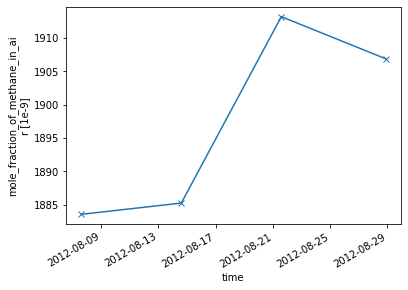

In [4]:
start_date = "2012-08-01"
end_date = "2012-09-01"

obs = get_obs_surface(site=site, species=species, start_date=start_date,
                        end_date=end_date, inlet=height, network=network)

mf = obs.data["mf"]
mf.plot(marker="x")

In [5]:
fp_file_path = "../data/footprints/TAC-100magl_EUROPE_201208.nc"

site="tac" 
height="100m"
domain="EUROPE"
model="NAME"

FOOTPRINTS.read_file(filepath=fp_file_path, site=site, height=height, domain=domain, model=model)

{'tac_europe_NAME_100m': '505ad72d-6328-4a2f-ae2c-791de3fd5510'}

In [6]:
flux_file_path = "../data/emissions/ch4-anthro_EUROPE_2012.nc"

species = "ch4"
domain = "EUROPE"
source = "anthro"
date = "2012"

Emissions.read_file(filepath=flux_file_path, species=species, source=source, domain=domain, date=date)

{'ch4_anthro_europe_2012': '44519d62-c1bc-4403-abef-1a6d94b0b2a6'}

In [7]:
# Use get_obs_surface to extract obs results from the object store
obs_surface = get_obs_surface(
    site=site, inlet=height, start_date=start_date, end_date=end_date, species=species)
# obs_results = obs_surface.data

/user/home/rt17603/work/environments/openghg_env/lib/python3.8/site-packages/xarray/core/indexes.py:97: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  indexer = index.slice_indexer(


In [8]:
# Extract footprint results from the object store
# TODO: This should be wrapped up into a function really
# all_footprint_results = search(site=site, domain=domain, height=height, start_date=start_date, end_date=end_date, data_type="footprint")
# uuid = list(all_footprint_results.keys())[0]
# footprint_keys = all_footprint_results[uuid]["keys"]

# footprint_results = recombine_datasets(keys=footprint_keys, sort=False) # Need this output to match to what we get from get_obs_surface e.g. get_footprint equivalent

footprint = get_footprint(site=site, domain=domain, height=height,
               start_date=start_date, end_date=end_date)

In [10]:
from openghg.modules import ModelScenario

model = ModelScenario(obs=obs_surface, footprint=footprint)

In [11]:
model.combine_obs_footprint(resample_to="coarsest")

<xarray.Dataset>
Dimensions:                    (time: 256, lon: 391, lat: 293, lev: 1, height: 20)
Coordinates:
  * time                       (time) datetime64[ns] 2012-08-07T14:50:30 ... ...
  * lon                        (lon) float32 -97.9 -97.55 -97.2 ... 39.03 39.38
  * lat                        (lat) float32 10.73 10.96 11.2 ... 78.82 79.06
  * lev                        (lev) object 'From     0 -    40m agl'
  * height                     (height) float32 500.0 1.5e+03 ... 1.95e+04
Data variables: (12/15)
    mf                         (time) float64 1.884e+03 nan ... nan 1.907e+03
    mf_variability             (time) float64 0.694 nan nan ... nan nan 0.276
    mf_number_of_observations  (time) float64 20.0 nan nan nan ... nan nan 20.0
    fp                         (lat, lon, time) float32 nan 0.0 0.0 ... 0.0 0.0
    temperature                (time) float32 nan 17.59 17.46 ... 19.89 18.31
    pressure                   (time) float32 nan 1.002e+03 ... 996.1 996.7
    ...                         ...
    release_lon                (time) float32 nan 1.139 1.139 ... 1.139 1.139
    release_lat                (time) float32 nan 52.52 52.52 ... 52.52 52.52
    particle_locations_n       (height, lon, time) float32 nan 0.0 ... 0.0 0.0
    particle_locations_e       (height, lat, time) float32 nan 0.0 ... 0.0 0.0
    particle_locations_s       (height, lon, time) float32 nan 0.0 ... 0.0 0.0
    particle_locations_w       (height, lat, time) float32 nan 0.0 ... 0.0 0.0

In [13]:
from openghg.processing import get_flux

species = "ch4"
domain = "EUROPE"
source = "anthro"
start_date = "2012-01-01"
end_date = "2013-01-01"

# Extract flux results from object store
# TODO: Decide if this should return a Emissions type object (as get_obs_surface does) or an xarray Dataset directly (as this does at the moment)
flux_results = get_flux(species=species,
                        domain=domain,
                        sources=source,
                        start_date=start_date,
                        end_date=end_date)

In [15]:
flux_results

FluxData(data=<xarray.Dataset>
Dimensions:  (lat: 293, lon: 391, time: 1)
Coordinates:
  * lat      (lat) float32 10.73 10.96 11.2 11.43 ... 78.36 78.59 78.82 79.06
  * lon      (lon) float32 -97.9 -97.55 -97.2 -96.84 ... 38.32 38.68 39.03 39.38
  * time     (time) datetime64[ns] 2012-01-01
Data variables:
    flux     (lat, lon, time) float32 4.122e-13 1.302e-13 1.386e-12 ... 0.0 0.0
Attributes: (12/21)
    title:                        ch4 emissions from EDGARv5.0 database.
    author:                       OpenGHG Cloud
    date_created:                 2021-03-31 16:29:46.917793
    number_of_prior_files_used:   1
    prior_file_1:                 EDGARv5.0
    prior_file_1_version:         v5.0
    ...                           ...
    end_date:                     2012-01-01 00:00:00+00:00
    max_longitude:                39.38
    min_longitude:                -97.89999
    max_latitude:                 79.057
    min_latitude:                 10.729
    time_resolution:       

In [14]:
# Add flux results
model.flux = flux_results

In [ ]:
# TODO: Want to calculate the modelled mole fraction using `model` when this has been written into the code

